# Environnement for the bike renting system


In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

## General Idea

On the one side, we have the user that is willing to rent a bike, and on the other hand we have the bike renter that needs to rent its bikes

We imagine a website where after giving (knowingly or not) some information, the user is showed a list of bikes and decides whether it wants to rent it.

We will define for each user a private array of dimension k of caracteristics that would define the embedding preferences of the user

Similarly for the bikes, each one will have an array of caracteristics (of same dimension : k)

This way, we can define how much the user would like the bike by simply calculating the similarity between the user and the bike

When we know how much a user wants a bike, we add a price sensitivity factor (probability to buy according to price), and a duration sensitivity factor (probability to buy according to how much the proposed renting period is right)

We assume that each bike is a cluster and user a uniforly normally distributed around these clustersw

An experience would be a list of user in a particular order

In [2]:
def similarity(x,y):
    X = np.array(x)
    Y = np.array(y)
    
    a = np.mean(X*X)
    b = np.mean(Y*Y)
    
    if a == 0 or b == 0:
        return 0
    else:
        return np.mean(X*Y)/np.sqrt(a*b)



class Person(object):
    
    def __init__(self,params,price_appetence,seed,user_id):
        
        """
        A person is defined by its public info (that the website can see) and its private params (that we don't know, but influence the behaviour)
        """
        
        self.params = params
        self.seed = seed
        self.rng = np.random.RandomState(seed)
        self.id = user_id
        self.price_appetence = price_appetence
        
        self.alter_params()

    
    def alter_params(self):
        pass
    
    
    
    @classmethod
    def randomPerson(cls,seed,dim,clusters,user_id):
        rng = np.random.RandomState(seed)
        
        n = len(clusters)
        c = clusters[rng.randint(n)]
        
        
        
        params = np.array([max(0,rng.normal(s,1)) for s in c])
        
        price_appetence = rng.uniform(1000)
        
        
        return cls(params,price_appetence,seed,user_id)
        
        
    def get_best_reward(self):
        pass
        
    def get_proba(self,bike,price,days,days_wanted):
        
        proba = similarity(bike.params,self.params)
        
        
        #print(np.exp(-price/self.price_appetence))
        
        proba = proba * np.exp(-price/self.price_appetence)
        
        proba = proba * np.exp(-abs(len(days) - len(days_wanted)))
        
        
        
        
        
        return proba
    
    def get_reward(self,bike,days,days_wanted):
        
        reward = similarity(bike.params,self.params)
       
        
        reward = reward * self.price_appetence
        
        reward = reward * np.exp(-abs(len(days) - len(days_wanted)))
        
        
        
        
        
        return reward
    
    def get_best_reward(self,bike_list,days_list,days_wanted):
        
        rewards = []
        
        for (bike,days) in zip(bike_list,days_list):
            rewards.append(self.get_reward(bike,days,days_wanted))
            
        return np.max(rewards)
        
    def which_bike(self,bike_list,days_list,price_list,days_wanted):
        
        
        probas = []
        
        for (bike,days,price) in zip(bike_list,days_list,price_list):
            probas.append(self.get_proba(bike,price,days,days_wanted))
            
            
        #print(probas)
            
        is_chosen = []
        prices = []
        
        for (i,p),price in zip(enumerate(probas),price_list):
            if self.rng.uniform() < p:
                is_chosen.append(i)
                prices.append(price)
                
        if len(is_chosen) == 0:
            return None,None
        else:
            a = self.rng.randint(len(is_chosen))
            
            return is_chosen[a],prices[a]
            
            
    
        

In [3]:
class Bike(object):
    def __init__(self,params,experiment_length,bike_id):
        self.params = params
        self.experiment_length = experiment_length
        
        days = list(range(self.experiment_length))
        price = [0]*self.experiment_length
        rented = [False]*self.experiment_length
        self.id = bike_id
        
        
        self.renting_data = pd.DataFrame({
            "day":days,
            "price":price,
            "rented":rented
        })
        
    def available_days(self,days):
        return self.renting_data[(self.renting_data.day.isin(days)) & (self.renting_data.rented == False)].day.values
    
    
    def rent(self,days,price):
        
        v = self.renting_data.rented.loc[self.renting_data.day.isin([days])].astype(int).sum()
        
        if v > 0:
            return False
        else:

            self.renting_data.rented.loc[self.renting_data.day.isin([days])] = True
            self.renting_data.price.loc[self.renting_data.day.isin([days])] = price
            
            return True

In [4]:
class Environnement(object):
    
    def __init__(self,params,seed):
        self.experiment_length = params["experiment_length"]
        self.seed = seed
        
        self.n_users = params["n_users"]
        self.n_clusters = params["n_clusters"]
        
        self.dim = params["dim"]
        
        self.users_per_day = params["users_per_day"]
        self.n_bikes_per_user = params["n_bikes_per_user"]
        
    def init(self):
        
        
        self.rng = np.random.RandomState(self.seed)
        
        
        
        
        self.clusters = [np.array([self.rng.uniform() for i in range(self.dim)]) for j in range(self.n_clusters)]
        
        
        self.peoples = [Person.randomPerson(s*seed,self.dim,self.clusters,s) for s in range(self.n_users)]
        
        
        
        self.bikes = [Bike(c,self.experiment_length,i) for (i,c) in enumerate(self.clusters)]
        
        
        self.t = 0
        
        self.users_seen = 0
        
        self.current_user = self.rng.choice(self.peoples)
        
        self.days_wanted = self.get_wanted_days()
        
        self.history = pd.DataFrame(columns = [
            "user_id",
            "days_wanted",
            "bike_proposed",
            "price_proposed",
            "days_proposed",
            "answer"
        ])
        
        
    def get_wanted_days(self):
        day1 = int(self.rng.exponential(20) + self.t)
        day2 = int(self.rng.exponential(8) + day1)
        
        days = list(range(day1,day2))
        
        return days
    
    def get_history(self):
        return self.history
    
        
    def get_context(self):
        
        return {
                "day":self.t,
                "user_id":self.current_user.id,
                "days_wanted":self.days_wanted,
                "bikes_available":[bike.id for bike in self.bikes],
                "bikes_availability":[bike.available_days(self.days_wanted) for bike in self.bikes]
            }
        
        
        
    
    def act(self,bike_list,days_list,price_list):
        
        if self.t == self.experiment_length:
            return "Experiment_over"
        
        bike_proposed = bike_list[:self.n_bikes_per_user]
        bike_list = [self.bikes[bike_id] for bike_id in bike_list][:self.n_bikes_per_user]
        
        
        indice_chosen,price = self.current_user.which_bike(bike_list,days_list,price_list,self.days_wanted)
        
        
        
        context = self.get_context()
        best_reward = self.current_user.get_best_reward([self.bikes[b] for b in context["bikes_available"]],context["bikes_availability"],self.days_wanted)
        
        

        result = None
        
        if indice_chosen != None:
            chosen_bike = bike_list[indice_chosen]
            
            result = chosen_bike.rent(days_list[indice_chosen],price_list[indice_chosen])
            
            if result:
                result = chosen_bike.id
            
        reward = price
        if result == None:
            result = "REFUSED"
            reward = 0
        elif result == False:
            result = "INVALID"
            reward = 0
        
            
            
        history_to_append = pd.DataFrame({
            "user_id":[self.current_user.id],
            "days_wanted":[self.days_wanted],
            "bike_proposed":[bike_proposed],
            "price_proposed":[price_list],
            "days_proposed":[days_list],
            "answer":[result],
            "reward":[reward],
            "best_reward":[best_reward]
        })
        
        self.history = pd.concat([self.history,history_to_append])
        
        
        
        self.users_seen =+ 1
        self.t = self.users_seen % self.users_per_day
        
        self.current_user = self.rng.choice(self.peoples)
        
        self.days_wanted = self.get_wanted_days()
        
        
        

        return result
        

In [5]:
class Policy(object):
    def __init__(self,params,seed):
        self.params = params
        self.seed = seed
        self.list_length = self.params["list_length"]
        
    def init(self):
        self.rng = np.random.RandomState(self.seed)
        
    def get_action(self,context):
        return context["bikes_available"],context["bikes_availability"],[self.params["price"] for i in range(len(context["bikes_available"]))]

In [6]:
params = {
    'experiment_length':365,
    "n_users":10000,
    "n_clusters":5,
    'dim':10,
    "n_bikes_per_user":5,
    "users_per_day":10
}
seed = 2
env = Environnement(params,seed)

env.init()

In [7]:
env.get_wanted_days()

[38, 39, 40, 41]

In [8]:
env.get_context()

{'day': 0,
 'user_id': 8211,
 'days_wanted': [1, 2, 3],
 'bikes_available': [0, 1, 2, 3, 4],
 'bikes_availability': [array([1, 2, 3]),
  array([1, 2, 3]),
  array([1, 2, 3]),
  array([1, 2, 3]),
  array([1, 2, 3])]}

  0%|          | 0/100 [00:00<?, ?it/s]/home/bnoyt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/bnoyt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 100/100 [00:07<00:00, 11.88it/s]


0.0


100%|██████████| 100/100 [00:06<00:00, 14.76it/s]


0.0


100%|██████████| 100/100 [00:04<00:00, 20.94it/s]


0.0


100%|██████████| 100/100 [00:04<00:00, 24.59it/s]


0.0


100%|██████████| 100/100 [00:03<00:00, 30.32it/s]


0.0


Text(0.5, 1.0, 'Regret for various values of the random price p')

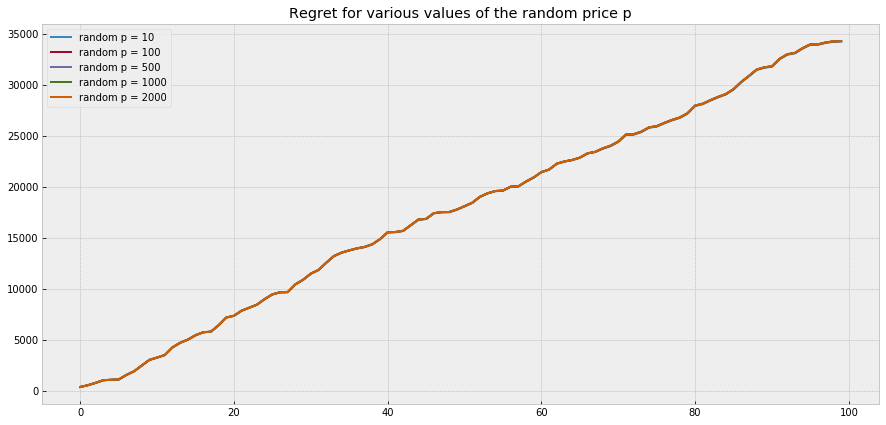

In [11]:
n_steps = 100
plt.style.use("bmh")
plt.figure(figsize=(15,7))

params = {
    'experiment_length':365,
    "n_users":10000,
    "n_clusters":5,
    'dim':10,
    "n_bikes_per_user":1,
    "users_per_day":10
}
seed = 2
env = Environnement(params,seed)

env.init()

policy = Policy({"list_length":5,"price":10},3)
for i in tqdm(range(n_steps)):
    context = env.get_context()
    b,d,p = policy.get_action(context)
    result = env.act(b,d,p)
    
df = env.get_history()

print(df.reward.mean())


regret = df.best_reward.cumsum() - df.reward.cumsum()

plt.plot(regret.values,label="random p = 10")

params = {
    'experiment_length':365,
    "n_users":10000,
    "n_clusters":5,
    'dim':10,
    "n_bikes_per_user":1,
    "users_per_day":10
}
seed = 2
env = Environnement(params,seed)

env.init()


policy = Policy({"list_length":5,"price":100},3)
for i in tqdm(range(n_steps)):
    context = env.get_context()
    b,d,p = policy.get_action(context)
    result = env.act(b,d,p)
    
df = env.get_history()

print(df.reward.mean())


regret = df.best_reward.cumsum() - df.reward.cumsum()

plt.plot(regret.values,label="random p = 100")

params = {
    'experiment_length':365,
    "n_users":10000,
    "n_clusters":5,
    'dim':10,
    "n_bikes_per_user":2,
    "users_per_day":10
}
seed = 2
env = Environnement(params,seed)

env.init()

policy = Policy({"list_length":5,"price":500},3)
for i in tqdm(range(n_steps)):
    context = env.get_context()
    b,d,p = policy.get_action(context)
    result = env.act(b,d,p)
    
df = env.get_history()

print(df.reward.mean())


regret = df.best_reward.cumsum() - df.reward.cumsum()

plt.plot(regret.values,label="random p = 500")

params = {
    'experiment_length':365,
    "n_users":10000,
    "n_clusters":5,
    'dim':10,
    "n_bikes_per_user":1,
    "users_per_day":10
}
seed = 2
env = Environnement(params,seed)

env.init()

policy = Policy({"list_length":5,"price":1000},3)
for i in tqdm(range(n_steps)):
    context = env.get_context()
    b,d,p = policy.get_action(context)
    result = env.act(b,d,p)
    
df = env.get_history()

print(df.reward.mean())


regret = df.best_reward.cumsum() - df.reward.cumsum()

plt.plot(regret.values,label="random p = 1000")

plt.legend()


params = {
    'experiment_length':365,
    "n_users":10000,
    "n_clusters":5,
    'dim':10,
    "n_bikes_per_user":2,
    "users_per_day":10
}
seed = 2
env = Environnement(params,seed)

env.init()

policy = Policy({"list_length":5,"price":2000},3)
for i in tqdm(range(n_steps)):
    context = env.get_context()
    b,d,p = policy.get_action(context)
    result = env.act(b,d,p)
    
df = env.get_history()

print(df.reward.mean())


regret = df.best_reward.cumsum() - df.reward.cumsum()

plt.plot(regret.values,label="random p = 2000")


plt.legend()

plt.title("Regret for various values of the random price p")

  0%|          | 0/100 [00:00<?, ?it/s]/home/bnoyt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 100/100 [00:07<00:00, 13.46it/s]

30.0


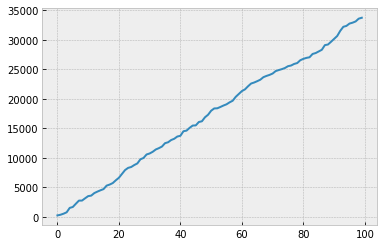

In [15]:
params = {
    'experiment_length':365,
    "n_users":100,
    "n_clusters":5,
    'dim':10,
    "n_bikes_per_user":2,
    "users_per_day":10
}
seed = 2
env = Environnement(params,seed)

env.init()

policy = Policy({"list_length":5,"price":100},3)
for i in tqdm(range(n_steps)):
    context = env.get_context()
    b,d,p = policy.get_action(context)
    result = env.act(b,d,p)
    
df = env.get_history()

print(df.reward.mean())


regret = df.best_reward.cumsum() - df.reward.cumsum()

plt.plot(regret.values,label="random p = 2000")

In [16]:
df

,answer,best_reward,bike_proposed,days_proposed,days_wanted,price_proposed,reward,user_id
0,1,356.238167,"[0, 1]","[[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, ...","[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4...","[100, 100, 100, 100, 100]",100.0,70
0,INVALID,114.207605,"[0, 1]","[[39, 40, 41, 42], [39, 40, 41, 42], [39, 40, ...","[39, 40, 41, 42]","[100, 100, 100, 100, 100]",0.0,68
0,REFUSED,178.098900,"[0, 1]","[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[100, 100, 100, 100, 100]",0.0,97
0,1,334.156666,"[0, 1]","[[14, 15, 16, 17, 18, 19, 20, 21, 22], [14, 15...","[14, 15, 16, 17, 18, 19, 20, 21, 22]","[100, 100, 100, 100, 100]",100.0,22
0,INVALID,747.195742,"[0, 1]","[[29], [29], [29], [29], [29]]",[29],"[100, 100, 100, 100, 100]",0.0,72
0,1,253.167657,"[0, 1]","[[12, 13, 14], [12, 13, 14], [12, 13, 14], [12...","[12, 13, 14]","[100, 100, 100, 100, 100]",100.0,16
0,1,650.039676,"[0, 1]","[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[100, 100, 100, 100, 100]",100.0,43
0,1,630.394790,"[0, 1]","[[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, ...","[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...","[100, 100, 100, 100, 100]",100.0,74
0,REFUSED,5.829617,"[0, 1]","[[7, 8, 9], [7, 8, 9], [7, 8, 9], [7, 8, 9], [...","[7, 8, 9]","[100, 100, 100, 100, 100]",0.0,30
0,1,484.512267,"[0, 1]","[[], [], [], [], []]",[],"[100, 100, 100, 100, 100]",100.0,63
